In [10]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
import seaborn as sns
from pandas import Grouper
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from hpsklearn import HyperoptEstimator, any_sparse_regressor
from hyperopt import tpe

import calmap
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import re
pd.set_option('display.max_colwidth', -1)


from IPython.core.display import HTML
import pprint
warnings.simplefilter(action='ignore', category=Warning)

In [11]:
font = "Roboto-Regular.ttf"
pp = pprint.PrettyPrinter(indent=4, width=100)


HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}


</style>


<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

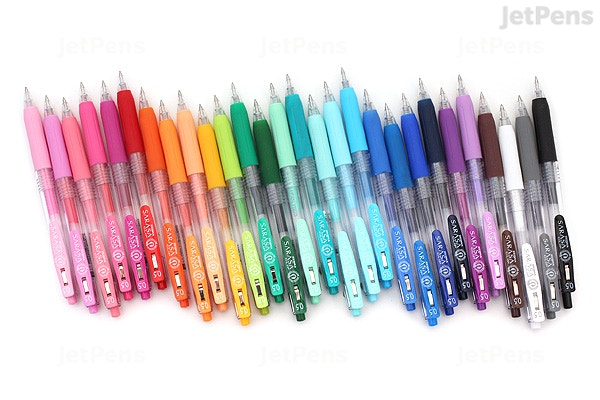

<div><center><span style="background-color: #ffffff; padding-top: 100px; padding-right: 50px; padding-bottom: 70px; padding-left: 20px; color: #e17f93; font-size: 40px; font-weight: bold">DEMAND FORECASTING FOR @TAFELPH </span></center><center><span style=" font-size: 20px;">by: Nicole Obrero</span></center></div>

<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">INTRODUCTION </span></div>

Tafelph is a [Shopee](https://shopee.ph/mari.ol.shop)-based online pen boutique. They sell specialty pens, markers and highlighters from popular Japanese brands like Zebra, Uni and Pilot. All of the items sold are for pre-order, and customers usually need to wait for at least a month to get hold of their ordered items. Due to the shop's per-order configuration, almost __52 %__ of the placed orders were canceled. *Figure 1* shows the increasing gap (cancellations) between demand and fulfilled orders. These cancellations are due to change of mind, misplaced orders, and most of the time, customers' impatience. With the ongoing pandemic causing limited supplier stocks, delays in customs and slow shipments, the delays in fulfillment are affecting the shop's high customer rating and good feedbacks in Shopee. On top of this, the shop's high cancellation rate earned penalty points from Shopee which has forced the shop to unlist all its products and stop taking orders for the meantime while trying to clear out pending orders. 

<a id='fig1'></a>

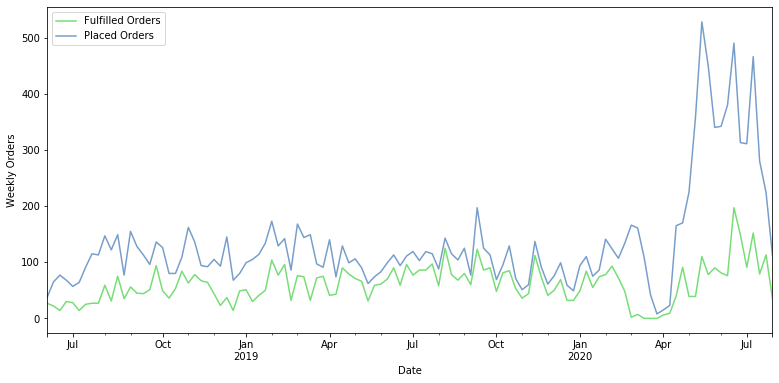

In [28]:
dfall = pd.read_csv('tafel.csv')

#convert to date time
dfall['Order Creation Date'] = pd.to_datetime(dfall['Order Creation Date'])

df = dfall.copy()

comp = df[df['Order Status'] == 'Completed'].drop(columns='Order Status').reset_index(drop=True)
canc = df[df['Order Status'] == 'Cancelled'].drop(columns='Order Status')

((comp.resample('W', on='Order Creation Date').count()['Quantity'].rename("Fulfilled Orders").reset_index()).merge
 (df.resample('W', on='Order Creation Date').count()['Quantity'].rename("Placed Orders").reset_index())
 .set_index('Order Creation Date')).plot.line(figsize=(13,6),color=['#77dd77','#779ecb']);
plt.xlabel("Date")
plt.ylabel("Weekly Orders");


<center>Figure 1. Increasing Gap between Orders Placed versus Orders Fulfilled </center>


<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">THE PROBLEM</span></div>

### Given limited time and resources, how can TafelPH reduce its cancellation rate? 

One of the solutions to this problem is having on-hand and ready to ship to customers stocks. But since the online shop is owned and run by a self-supporting med student, the capital is only limited. Aside from this, Tafel has a wide variety of products like pens, highlighters, pencils and markers of different color, sizes and types from 12 different brands adding up to __1,331 SKUs__. It is not feasible for the shop to store inventory for every SKU due to budget and space constraints. However, top fast-moving SKUs (or those items that are frequently ordered) can be identified, and forecast the demand in the next few weeks. In doing so, the shop will have an idea of the expected volume of transactions in the next few weeks and plan its resources to acquire enough inventory to satisfy customers' demand, at least for the top SKUs identified. 


</b>





<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">METHODOLOGY</span></div>


__The following steps were carried out to come up with a forecasting model for TafelPH:__

1. Data Extraction
2. Data Cleaning and Transformation
3. Exploratory Data Analysis
4. Feature Engineering and Further Pre-processing
5. Machine Learning Model and Hyperparameter Tuning

<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">DATA EXTRACTION AND CLEANING</span></div>

The shop's daily order transactions were extracted from Shopee database. For this study, I have only considered transactions from June 2018 to July 2020 as sales only started to become stable in June 2019. 

Monthly files were combined and undergone initial cleaning. The resulting data is shown in [Table 1](#tab1). The sample data is shown in [Table 2](#tab2).



__Table 1. Data Description__

|Data Field|Description|
|----------|-----------|
|Order Creation Date |Date order was placed|
|Order ID| Unique ID the transaction|
|SKU ID| Item variant ID |
|SKU| Item description |
|Brand| Brand/Manufacturer of the Item |
|Category| Category the item belongs to |
|Item Price| Per unit price of the item in PhP|
|Quantity|Count of items bought|





__Table 2. Sample Input Data__

In [29]:
comp.head()

,Order ID,SKU,Order Creation Date,SKU ID,Brand,Original Price,Quantity,Category
0,18070717543J5X8,"Zebra Mildliners, Warm Colors; All 5",2018-07-07 17:54:00,1145,Zebra,360,1,Highlighter
1,18070721153SQ1T,"Uni Propus, Soft; Set of 5",2018-07-07 21:15:00,818,Uni,360,1,Highlighter
2,180708214539J9Q,Kokuyo Beetle Tip Dual Color Highlighters - Soft; All 3,2018-07-08 21:45:00,11,Kokuyo,450,3,Highlighter
3,18071309043PV50,"Zebra Mildliners, Peach Set; Set of 5",2018-07-13 09:04:00,1113,Zebra,480,3,Highlighter
4,180717203132NRX,"Uni Propus, Soft; Bright yellow",2018-07-17 20:31:00,814,Uni,90,1,Highlighter


<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">EDA HIGHLIGHTS</span></div>

[Figure 1](#fig1) displays an over-all increasing trend in TafelPH's demand throughout the years, with dips observed every now and then. The same trend is revealed on the calendar plot in [Figure 2](#fig2). Generally, there are more orders are placed on weekdays than on weekends. And as expected, days in June, July and August, when enrollment and classes start, are those with relatively more transactions. The shop received the highest volume of orders in one of the Mondays of September and November. This is most likely due to Shopee's 9.9 and 11.11 sale campaigns.
<a id='fig2'></a>

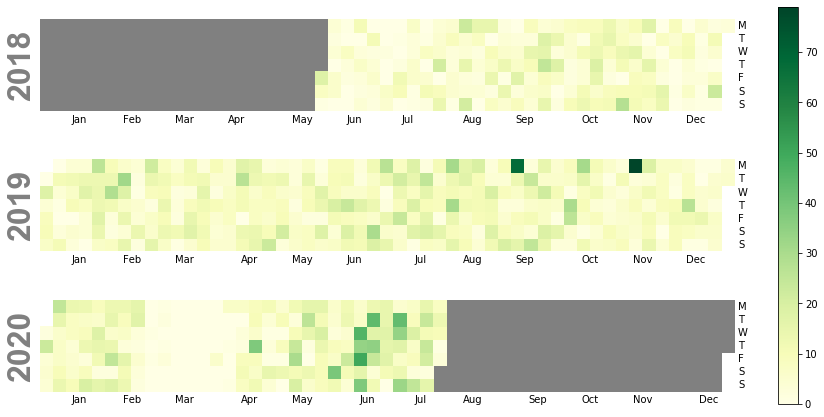

In [30]:
cal = comp.resample("D", on='Order Creation Date')['Order ID'].count()
fig, ax=calmap.calendarplot(cal, daylabels='MTWTFSS',
                    dayticks=[0, 1,2,3, 4,5, 6], cmap='YlGn',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(13, 6)));
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());

<center>Figure 2. Volume of Daily Orders  

Exploring the types of products being sold, I have uncovered that pens contribute to almost half of the revenue ([Figure 3](#fig3)) while in terms of brand, Uni takes up a huge chunk of the revenue ([Figure 4](#fig4)).  

<a id='fig3'></a>

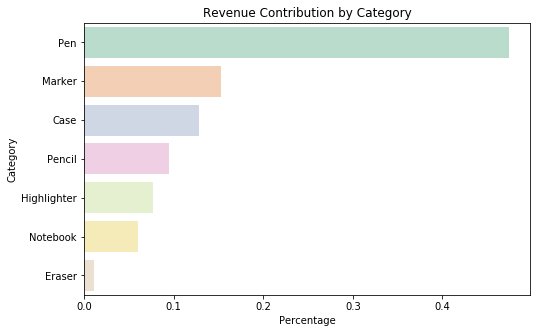

In [31]:
comp['Revenue'] = comp['Quantity'] * comp['Original Price']

y = comp.groupby('Category')['Revenue'].sum().reset_index().sort_values(by='Revenue',ascending=False)

y['Percentage'] = y['Revenue']/y['Revenue'].sum()
y
plt.subplots(figsize=(8,5))
sns.barplot(x= 'Percentage',y='Category', data=y, palette='Pastel2')
plt.title("Revenue Contribution by Category");

<center>Figure 3. Revenue Contribution per Product Category </center>
<a id='fig4'></a>

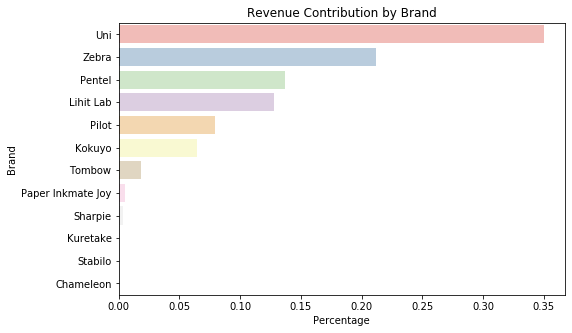

In [32]:
x = comp.groupby('Brand')['Revenue'].sum().reset_index().sort_values(by='Revenue',ascending=False)
x['Percentage'] = x['Revenue']/x['Revenue'].sum()
plt.subplots(figsize=(8,5))
sns.barplot(x= 'Percentage',y='Brand', data=x, palette='Pastel1')
plt.title("Revenue Contribution by Brand");

<center>Figure 4. Brand Contribution to Total Revenue </center>
<a id='fig5'></a>

Looking closely into the individual items sold, the top 11 SKUs were identified in [Figure 5](#fig5). These SKUs will be used as the scope of the study for simplicity and usability of the forecast to the shop's owner.

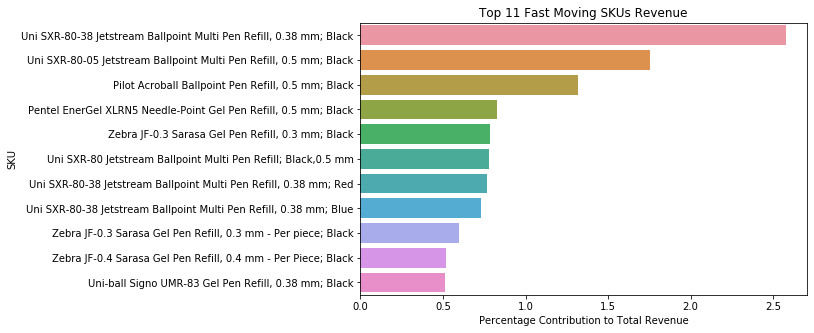

In [33]:
plt.subplots(figsize=(8,5))
topn = 11
top_rev = comp.groupby(['SKU ID', 'SKU']).sum().sort_values(ascending=False, by= 'Quantity')[['Quantity', 'Revenue']].reset_index()#.plot(kind='barh')
top_rev['Percentage'] = top_rev['Revenue']/top_rev['Revenue'].sum() *100

# print("Revenue contribution: ",top_rev[:topn]['Percentage'].sum() )
# top_rev[:topn].drop(columns='Revenue')

sns.barplot(x='Percentage', y='SKU', data=top_rev[:topn])
plt.xlabel("Percentage Contribution to Total Revenue")
plt.title("Top 11 Fast Moving SKUs Revenue");

# #SCOPING
top12 = top_rev[:topn]['SKU ID'].tolist()
tafel1 = (comp[comp['SKU ID'].isin(top12)] )

<center>Figure 5. Top 11 fast moving SKUs makes up 11 % of the total revenue

<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">MACHINE LEARNING MODELS</span></div>

Forecasting can be done using ARIMA or any regressor models. For this project, I have explored ARIMA, Decision Tree, Random Forest and Gradient Boosting Regressor algorithms. Random forests and GBM are typically not used in forecasting time series data. However, lagged time series data can be used as features for modeling. Product features such as name, brand, category, and price can also be incorporated. It can also forecast sales for multiple products at the same time, unlike ARIMA which can only predict one product at one time. 

## REGRESSOR MODELS
### 1. Feature Engineering

A simple yet strong relationship between input and output features is preferred by the models, and one of the ways to achieve this is by doing feature engineering. 

1. Time series datasets are usually univariate and only have little information to transform, but luckily  features, such as product information and price, are available. 
2. Data was aggregated per SKU weekly because there are days with 0 demand.
3. I also added lagged time series features. After implementation ([Table 3](#tab3)), every row now contains certain SKU and its corresponding demand for a specific week along with previous 3 weeks demand (lag) value of that SKU. 
4. All categorical variables were one-hot encoded.

In [34]:
def moreclean(tafel1):
        
 
    tafel1['month'] = tafel1['Order Creation Date'].dt.month    
    tafel1['week'] = tafel1['Order Creation Date'].dt.week
    tafel1['year'] = tafel1['Order Creation Date'].dt.year -2018
    
    #group SKUs weekly demand
    data = (tafel1.groupby(['SKU', 'SKU ID', 'month','week','year'])
                .agg({'Quantity': 'sum', 'Original Price': 'sum'}).reset_index())
    
    #transform item description as features
    s = (data['SKU']).str.split('; |,| |\n')
    coldrop=['', '-','Pen','Per','Piece', 'mm', 'piece']
    data = pd.concat([data, pd.get_dummies(s.apply(pd.Series).stack())
                       .sum(level=0).drop(columns=coldrop).reset_index(drop=True)],axis=1)    
    

    #add 3 lag features for every SKU for 
    data = data.sort_values(by=['year','month','week'],ascending=[True,True,True])
    data['q_lag1'] = data.groupby('SKU ID')['Quantity'].shift(1)
    data['q_lag2'] = data.groupby('SKU ID')['Quantity'].shift(2)
    data['q_lag3'] = data.groupby('SKU ID')['Quantity'].shift(3)
    data.dropna(inplace=True)

    #OHE
    data = pd.get_dummies(data, 
                    prefix=['SKU ID', 'month','year', 'week'],
                    columns=['SKU ID', 'month', 'year','week',])

    data = data.drop(columns = [ 'SKU'])
    

    return data

__Table 3. Transformed Dataset__

In [35]:
data = moreclean(tafel1)
data.head()

,Quantity,Original Price,0.3,0.38,0.4,0.5,Acroball,Ballpoint,Black,Blue,EnerGel,Gel,JF-0.3,JF-0.4,Jetstream,Multi,Needle-Point,Pentel,Pilot,Red,Refill,SXR-80,SXR-80-05,SXR-80-38,Sarasa,Signo,UMR-83,Uni,Uni-ball,XLRN5,Zebra,q_lag1,q_lag2,q_lag3,SKU ID_281,SKU ID_384,SKU ID_847,SKU ID_855,SKU ID_863,SKU ID_864,SKU ID_865,SKU ID_970,SKU ID_1050,SKU ID_1054,SKU ID_1058,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_0,year_1,year_2,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,week_15,week_16,week_17,week_18,week_19,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,week_36,week_37,week_38,week_39,week_40,week_41,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
446,10,60,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,19.0,8.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
447,6,60,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,10.0,19.0,8.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
448,21,120,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,6.0,10.0,19.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
449,2,60,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,21.0,6.0,10.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,1,60,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,2.0,5.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2. Hyperparameter Tuning and Model Evaluation

Feature engineering produced a matrix with 444 records by 112 features. 

The dataset was split into 90 % train and 10 % test. The metric that will be used to evaluate the machine learning model performance is __RMSE__ (Root Mean Squared Error). RMSE gives a relatively high weight to large errors. Large errors are undesirable because that would mean either overstocking (less working capital) or under-stocking (unfulfilled orders). 

RandomSearchCV and GridSearchCV was utilized in hyperparameter tuning. Out of the three tree-based algorithms, GradientBoostingRegressor has the lowest RMSE at __3.77__, closely followed by RandomForest at __3.93__. Predicted values produced by GBM Regressor is visualized in [Figure 6](#fig6). The resulting models are summarized in [Table 4.](#tab4)

In [36]:
#TIME SPLITTING 90-10

num = int(len(data) * 0.10)

test_data = data[-num:]  
train_data = data[:-num]   


#test and train
X_train, y_train = train_data.drop(columns='Quantity'), train_data.Quantity
X_test, y_test = test_data.drop(columns='Quantity'), test_data.Quantity

DT = DecisionTreeRegressor(max_depth =4) 
DT.fit(X_train,y_train)

RF = RandomForestRegressor(max_depth =5,n_estimators=300,max_features=50)
RF.fit(X_train,y_train)


GBM = GradientBoostingRegressor(max_depth =3,learning_rate=0.009,n_estimators=800,max_features=35) 
GBM.fit(X_train,y_train)


y_test_DT = DT.predict(X_test)
y_test_RF = RF.predict(X_test)
y_test_GBM = GBM.predict(X_test)


cols = (['Machine Learning Regression Method', 'Train Accuracy','Test Accuracy','RMSE', 'Top Predictors'])
df2 = pd.DataFrame(columns=cols)

                                                                          
df2.loc[0] = (['Decision Tree', DT.score(X_train,y_train),
               DT.score(X_test,y_test), 
               sqrt(mean_squared_error(y_test , y_test_DT)),
               list(X_train.columns[np.argsort(DT.feature_importances_)[-2:]])
              ])

df2.loc[1] = (['Random Forest', RF.score(X_train,y_train), 
               RF.score(X_test,y_test),\
               sqrt(mean_squared_error(y_test , y_test_RF)),
               list(X_train.columns[np.argsort(RF.feature_importances_)[-2:]])
              ])


df2.loc[2] = (['Gradient Boosting Method',GBM.score(X_train,y_train),
               GBM.score(X_test,y_test),
               sqrt(mean_squared_error(y_test , y_test_GBM)),
               list(X_train.columns[np.argsort(GBM.feature_importances_)[-2:]])
              ])

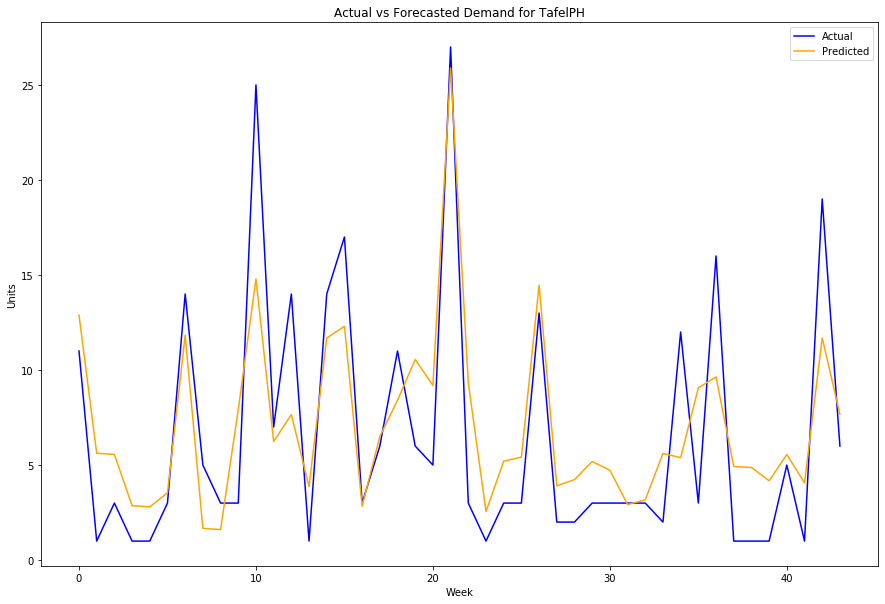

In [37]:
fig = plt.figure(figsize=(15, 10))
number= np.arange(len(y_test)) 
plt.plot(number, y_test, color='blue')
plt.plot(number, y_test_GBM,color='orange')
plt.legend(["Actual", "Predicted"])
plt.title("Actual vs Forecasted Demand for TafelPH")
plt.xlabel("Week")
plt.ylabel("Units");

<center>Figure 6. Actual and Forecasted Demand using GBM Regressor

## ARIMA
### 1. Check  if the timeseries is stationary using Augmented Dickey Fuller (ADF) Test

The results show that the test statistic value -4.603691 is smaller than the critical value at 1% of --3.491. This suggests that we can reject the null hypothesis with a significance level of less than 1%. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary and differencing is not necessary.

In [38]:
# CHECK IF STATIONARY
weekly_orders = tafel1.resample("W", on = 'Order Creation Date')['Quantity'].sum()
series = weekly_orders.copy()
result = adfuller(weekly_orders)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) 
#p < \alpha reject the null hypothesis (system has no unit root = stationary)
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.603691
p-value: 0.000127
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581


### 2. Establish Baseline RMSE 
TAFELPH does not used existing forecasting method so we will just use the naive forecast as the baseline. The value at the previous time step (t-1) is used to predict the expected outcome at the next time step (t+1). Baseline model gives out an __RMSE of 14.969__, almost 3x than that of GBM Regressor.

In [39]:
X = weekly_orders.values
X = X.astype('float32')
train_size = int(len(X) * 0.9)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = train.tolist()#[x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('BASELINE RMSE: %.3f' % rmse)


df2.loc[3] = (['Naive Forecast Baseline', "-","-",rmse,"-"])

BASELINE RMSE: 14.969


### 3. ARIMA Hyperparameter Tuning and Model Evaluation
Grid Search was used to iteratively explore different combinations of parameters. ARIMA order at (2, 1, 1) gives an __RMSE of 12.934__, only slightly better than the baseline RMSE. 

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.9)
    train, test = X[0:train_size], X[train_size:]
    # make predictions
    predictions = list()   
    for t in range(len(test)):
        model = ARIMA(train, order=arima_order) 
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]           
        predictions.append(yhat)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s with RMSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(weekly_orders, p_values, d_values, q_values)

In [ ]:
rmse = evaluate_arima_model(weekly_orders, (2,1,1))
df2.loc[4] = (['ARIMA (2,1,1)', "-","-",rmse,"-"])

__Table 4. Summary of Model Performances__

In [ ]:
df2

Over-all, Gradient Boosting Regressor is the best model based on RMSE. An overstock or understock of 4 items is already acceptable to the shop owner. The model also identified Original Price and demand at the previous 2 weeks (q_lag2) as the top contributors to the predictions. This buying pattern can be associated with paydays given every two weeks. 

<div><span style="background-color: #f4c2c2; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: black; font-size: 20px; font-weight: bold">SUMMARY AND TAKEAWAYS</span></div>

1. Understanding the Problem is half the solution. You can only achieve this when you communicate and ask a LOT of questions to your stakeholder. Before diving into finding the solution, you should understand and be clear about what he/she wants and needs. 
2. Allot a SIGNIFICANT amount of time cleaning and making sure that the data is good quality because of garbage in, garbage out. Initially, all data points were included but that gave very low accuracy because it was found out that there more days with 0 sales in the early days of the shop. Upon finding the right range of data, the model gave better results. 
3. In every machine learning model that we build, always think of the end goal. The end goal is not to have the highest accuracy, lowest RMSE, etc but on how it can bring value. Models can make our lives simpler, but it can also give out complicated, uninterpretable results. There are a lot of ML models available out there but it is important to know which ones are appropriate for your problem.


In [ ]:
! jupyter nbconvert --to html Obrero_MLIndividual.ipynb.